# 0.0 IMPORTS

## packages

In [1]:
import os, pickle, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as ss
import sweetviz as sv
import matplotlib.gridspec as gridspec
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection            import train_test_split
from sklearn.preprocessing              import RobustScaler,MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.base                       import BaseEstimator, TransformerMixin
from IPython.display                    import Image
from sklearn.linear_model               import LinearRegression, Lasso
from sklearn.ensemble                   import RandomForestClassifier
from boruta                             import BorutaPy
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline

pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

p:\Anaconda3\envs\insurance_cross\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'p:\\Python\\GitHub\\insurance_cross'

## helper classes

## helper funcions 

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 16]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

## data import

In [ ]:
df0=pd.read_csv(r"data/train.csv")
test=pd.read_csv(r"data/test.csv")
df0.head(1)

# split

In [ ]:
X=df0.drop('Response',axis=1)
y=df0['Response']

Xtrain, Xtest0, ytrain, ytest0 = train_test_split(X,y, random_state=42,  test_size=0.40, stratify=y)

df0_train=pd.concat([Xtrain,ytrain],axis=1)

holdout=pd.concat([Xtest0,ytest0],axis=1)
holdout.to_csv(r"data/holdout.csv")


df0_train.head()

# metadata

In [ ]:
Image('img/metadata.png')

# 1.0 DATA DESCRIPTION

## 1.1 rename columns

In [ ]:
df1=df0_train.copy()
df1.columns=df1.columns.str.lower()
df1.head(1)

## 1.2 data dimensions

In [ ]:
df1.shape

## 1.3 data types

In [ ]:
df1.dtypes.sort_values()

In [ ]:
#convert categoric features (region_code, policy_sales_channel) to object:
for i in ['region_code','policy_sales_channel']:
    df1[i]=df1[i].astype('object')

## 1.4 check NA

In [ ]:
df1.isna().sum()

## 1.5 fillout NA

## 1.6 descriptive statistics for numeric attributes

In [ ]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T

# 2.0 FEATURE ENGINEERING

## 2.1 hypotesis mapping

In [ ]:
df2=df1.copy()

In [ ]:
Image('img/mindmap.png')

## 2.2 hypoteses list

## 2.3 feature creation

## 2.4 rename object values: vehicle age

In [ ]:
df2['vehicle_age'].unique()

In [ ]:
df2['vehicle_age']=df2['vehicle_age'].map({'> 2 Years':'2. 2_more_years','1-2 Year':'1. 1_2_years', '< 1 Year': '0. 1_less_years'})
print(df2['vehicle_age'].unique())
df2.head(1)

# 3.0 FEATURE FILTERING

In [ ]:
df3=df2.copy()

## 3.1 row filtering

## 3.2 cols filtering

# 4.0 EXPLORATORY DATA ANALYSIS

In [ ]:
df4=df3.copy()

## 4.1 univariate analysis

In [ ]:
my_report = sv.analyze(df2,target_feat='response')
my_report.show_html("descritive analysis.html")
my_report.show_notebook()

In [ ]:
df4.select_dtypes(include='object').columns

In [ ]:
for i in df4.select_dtypes(include='object').columns:
    sns.countplot(y=df4[i])
    plt.show()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

## 4.2 bivariate analysis and hypoteses testing

### H1. Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.
### **FALSE** There's no relationship between Associate Time and propensity buting vehicle insurance.

In [ ]:
aux1 = df4[['vintage', 'response']].groupby( 'vintage' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='vintage', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['vintage_binned']=pd.qcut(df4['vintage'],10)
aux2 = aux1[['vintage_binned', 'response']].groupby( 'vintage_binned' ).mean().reset_index()
sns.barplot( x='vintage_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### H2. Previously insured customers buys MORE vehicle insurance.
### **FALSE** Previously insured customers buys LESS vehicle insurance.

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('previously_insured')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='previously_insured',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)


### H3. Customers with driver licence buys MORE vehicle insurance.
### **TRUE** Customers with driver licence buys MORE vehicle insurance.

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})


aux = df4.groupby('driving_license')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='driving_license',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

### **H4.** OLDERS customers buys MORE vehicle insurance.
### **FALSE** OLDERS customers buys LESS vehicle insurance, but the youngest customers either.

In [ ]:
aux1 = df4[['age', 'response']].groupby( 'age' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='age', y='response', data=aux1 );

plt.subplot( 1, 3, 2 )
aux1['age_binned']=pd.qcut(df4['age'],10)
aux2 = aux1[['age_binned', 'response']].groupby( 'age_binned' ).mean().reset_index()
sns.barplot( x='age_binned', y='response', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### **H5.** There's a difference in propensity to purchase between customers GENDERS.
### **True** MALE customers are slighly more likely to buy vehicle insurance.

In [ ]:
aux = df4.groupby('gender')['response'].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('percent').reset_index()

g = sns.catplot(x='gender',y='percent',hue='response',kind='bar',data=aux)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H6. There's a DIFFERENCE in propensity to purchase between REGION CODE
### True. There's regions with more propense purchase customers.

In [ ]:
aux1 = df4[['region_code', 'response']].groupby( 'region_code' ).mean().reset_index().sort_values('response')
aux1['region_code']=aux1['region_code'].astype(str)

sns.barplot( x='region_code', y='response' ,data=aux1);

### H7. Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.
### FALSE the HIGHEST insurance prices is MORE BOUGHT by customers.

In [ ]:
aux1=df4.copy()
aux1['annual_premium_q']=pd.qcut(aux1['annual_premium'],4)
aux1=aux1.groupby(['annual_premium_q']).agg({'response':'mean'}).reset_index()
g=sns.catplot(x='annual_premium_q',y='response',data=aux1,kind='bar')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

### H8. UNDERAGED vehicles are MORE likely to be insured by customers.
###  **TRUE** UNDERAGED vehicles are MORE likely to be insured by customers.

In [ ]:
aux1 = df4[['vehicle_age', 'response']].groupby( 'vehicle_age' ).mean().reset_index().sort_values('response')
aux1['vehicle_age']=aux1['vehicle_age'].astype(str)
print(df4['vehicle_age'].value_counts())
g=sns.catplot(x='vehicle_age',y='response',data=aux1,kind='bar')
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    fig = plt.gcf()
    fig.set_size_inches(27.5, 12.5)

In [ ]:
### H9. DAMAGED vehicles are MORE likely to be insured by customers.

###  **True** DAMAGED vehicles are VERY MORE LIKELY to be insured by customers.

In [ ]:
aux1 = df4.groupby( 'vehicle_damage').agg(response_count=('response','count'),
                                                response_mean=('response','mean')).reset_index().sort_values('vehicle_damage')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(x='vehicle_damage',y='response_mean',data=aux1,ax=ax1)
sns.barplot(x='vehicle_damage',y='response_count',data=aux1,ax=ax2)


### H9. There is different insurance buy propensity according to policy sales channel. 

###  **True** there is a considerable difference in buy propensity depending to policy sales channel, however there is a big imbalance between the channels.

In [ ]:
aux1 = df4.groupby( 'policy_sales_channel' ).agg(response_count=('response','count'),
                                                response_mean=('response','mean')).reset_index().sort_values('policy_sales_channel')

fig = plt.figure(figsize=(20,10))
specs=gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1= fig.add_subplot(specs[0,0])
ax2= fig.add_subplot(specs[0,1])

g=sns.barplot(y='policy_sales_channel',x='response_mean',data=aux1,ax=ax1)
g=sns.barplot(x='policy_sales_channel',y='response_count',data=aux1,ax=ax2)


## hypoteses summary

In [ ]:
hyp={
"Customers with HIGH ASSOCIATE TIME with the company buys MORE vehicle insurance.":False,
"Customers previously insured buys MORE vehicle insurance.":False,
"Customers with driver licence buys MORE vehicle insurance.":True,
"OLDERS customers buys MORE vehicle insurance.":False,
"There's a difference in propensity to purchase between customers GENDERS.":True,
"There's a difference in propensity to purchase between region CODE":True,
"Customers with HIGH vehicle insurance price should buys LESS vehicle insurance.":False,
"UNDERAGED vehicles are MORE likely to be insured by customers.":True,
"There is different insurance buy propensity according to Policy Sales Channel.":True,
}
summary=pd.DataFrame.from_dict(hyp,orient='index').reset_index().rename(columns={'index':'hypotesis',0:'Conclusion'})
summary

## 4.3 multivariate analysis

In [ ]:
corrs= df2.select_dtypes(include=['float64','int64']).corr(method='pearson')
matrix = np.triu(corrs)
sns.heatmap(corrs,annot=True,mask=matrix)
plt.gcf().set_size_inches(22,16)

In [ ]:
# Calculate cramer V
a1 = cramer_v( df2['gender'], df2['gender'] )
a2 = cramer_v( df2['gender'], df2['vehicle_age'] )
a3 = cramer_v( df2['gender'], df2['vehicle_damage'] )

a4 = cramer_v( df2['vehicle_age'], df2['gender'] )
a5 = cramer_v( df2['vehicle_age'], df2['vehicle_age'] )
a6 = cramer_v( df2['vehicle_age'], df2['vehicle_damage'] )

a7 = cramer_v( df2['vehicle_damage'], df2['gender'] )
a8 = cramer_v( df2['vehicle_damage'], df2['vehicle_age'] )
a9 = cramer_v( df2['vehicle_damage'], df2['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )



sns.heatmap( d, annot=True)
plt.gcf().set_size_inches(18,16)

# 5.0 DATA PREPARATION

In [ ]:
df5=df4.copy()

#make directory to save the serialized transformers
os.makedirs("parameters",exist_ok=True)

In [2]:
df5=pickle.load(open("df5.pkl",'rb'))
df5.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,Male,49,1,41.00000,0,1. 1_2_years,Yes,30123.00000,124.00000,109,0
244933,244934,Female,64,1,8.00000,0,1. 1_2_years,Yes,40700.00000,124.00000,241,0


## 5.1 Encoding

In [3]:
obj=df5.select_dtypes(include='object').columns
df5[obj].nunique()

gender                    2
region_code              53
vehicle_age               3
vehicle_damage            2
policy_sales_channel    150
dtype: int64

In [4]:
#Ordinal Encoding
oe=OrdinalEncoder()
df5[['vehicle_age','gender','vehicle_damage']]=oe.fit_transform(df5[['vehicle_age','gender','vehicle_damage']])
#pickle.dump(oe,open("parameters/oe_vehicle_age_gender_vehicle_damage.pkl","wb"))
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,1.00000,49,1,41.00000,0,1.00000,1.00000,30123.00000,124.00000,109,0
244933,244934,0.00000,64,1,8.00000,0,1.00000,1.00000,40700.00000,124.00000,241,0
189344,189345,0.00000,24,1,11.00000,1,0.00000,0.00000,2630.00000,152.00000,120,0
232120,232121,0.00000,43,1,17.00000,1,1.00000,0.00000,2630.00000,152.00000,159,0
304224,304225,0.00000,29,1,10.00000,1,0.00000,0.00000,2630.00000,152.00000,117,0


## 5.2 Target encoding with additive smoothing

In [5]:
for i in ['region_code','policy_sales_channel']:
    df5[f'{i}']=(df5[i].map(df5.groupby(i)['response'].mean()))/df5['response'].mean()
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
215726,215727,1.00000,49,1,1.00710,0,1.00000,1.00000,30123.00000,1.53489,109,0
244933,244934,0.00000,64,1,0.78537,0,1.00000,1.00000,40700.00000,1.53489,241,0
189344,189345,0.00000,24,1,0.94647,1,0.00000,0.00000,2630.00000,0.23764,120,0
232120,232121,0.00000,43,1,0.59086,1,1.00000,0.00000,2630.00000,0.23764,159,0
304224,304225,0.00000,29,1,0.44775,1,0.00000,0.00000,2630.00000,0.23764,117,0


## 5.3 Split dataframe in train and test

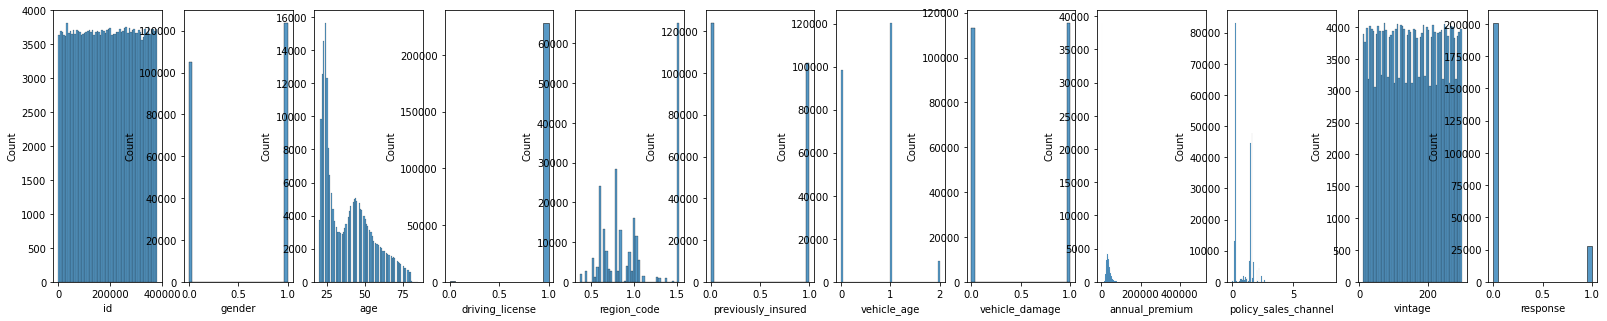

In [6]:
fig = plt.figure(figsize=(30,5))
specs=gridspec.GridSpec(nrows=1, ncols=13, figure=fig)

for n,i in enumerate(df5.select_dtypes(exclude='object').columns):
    ax1= fig.add_subplot(specs[0,n])
    sns.histplot(df5[i],ax=ax1)

## 5.4 Rescaling

In [7]:
#Feature age, region_code has an upper and lower boundaries well know. (Hardly you'll find someone with 150 years old or someone with -3 years old). Therefore MinMaxScaler will be used on it.
mms = MinMaxScaler()
for i in ['region_code','age']:
    df5[i] = mms.fit_transform( df5[[i]].values )
    pickle.dump( mms, open( f'parameters/{i}_mms_scaler.pkl', 'wb') )


#Feature vintage follows a normal distribution, thus StandardScaler will be used on it.
ss=StandardScaler()
df5['vintage'] = ss.fit_transform( df5[['vintage']].values )
pickle.dump( ss, open( 'parameters/vintage_ss_scaler.pkl', 'wb') )


#Annual premium and policy sales channel has some extreme values, so RobustScaler will be used on it.
rs = RobustScaler()
for i in ['annual_premium','policy_sales_channel']:
    df5[i] = rs.fit_transform( df5[[i]].values )
    pickle.dump( rs, open( f'parameters/{i}_robust_scaler.pkl', 'wb') )


In [8]:
mms=pickle.load(open("parameters/age_mms_scaler.pkl",'rb'))
df5['age'] = mms.transform( df5[['age']].values )
mms=pickle.load(open("parameters/region_code_mms_scaler.pkl",'rb'))
df5['region_code'] = mms.transform( df5[['region_code']].values )
ss=pickle.load(open("parameters/vintage_ss_scaler.pkl",'rb'))
df5['vintage'] = ss.transform( df5[['vintage']].values )
rs=pickle.load(open("parameters/annual_premium_robust_scaler.pkl",'rb'))
df5['annual_premium'] = rs.transform( df5[['annual_premium']].values )
rs=pickle.load(open("parameters/policy_sales_channel_robust_scaler.pkl",'rb'))
df5['policy_sales_channel'] = rs.transform( df5[['policy_sales_channel']].values )


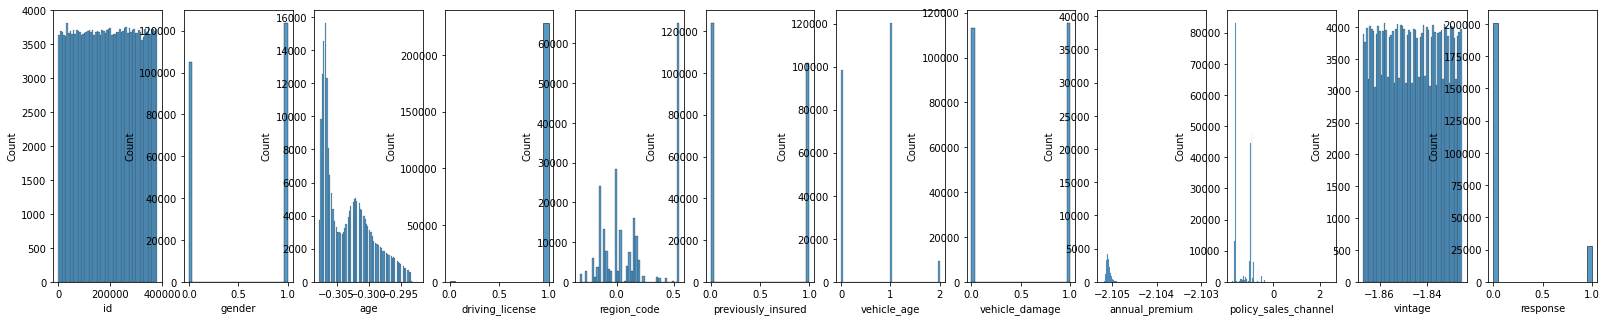

In [9]:
fig = plt.figure(figsize=(30,5))
specs=gridspec.GridSpec(nrows=1, ncols=13, figure=fig)

for n,i in enumerate(df5.select_dtypes(exclude='object').columns):
    ax1= fig.add_subplot(specs[0,n])
    sns.histplot(df5[i],ax=ax1)

##  5.5 target variable transformation

In [10]:
#There's no need to rescale binary target variable

# 6.0 FEATURE SELECTION

In [11]:
df6=df5.copy()
df6=df6.reset_index(drop=True)
ytrain=df6['response']
Xtrain=df6.drop(['response','id'],axis=1)
Xtrain.head(2)

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,1.00000,-0.30083,1,0.15819,0,1.00000,1.00000,-2.10511,-0.95784,-1.85286
1,0.00000,-0.29728,1,-0.00819,0,1.00000,1.00000,-2.10507,-0.95784,-1.83399


## 6.1 select K-Best

In [12]:
Xtrain0, Xval, ytrain0, yval = train_test_split(Xtrain,ytrain, test_size=0.25, stratify=ytrain)


k_vs_score=[]
dic_feat={}
for i in range(3,Xtrain0.shape[1]):
    selector = SelectKBest(score_func=f_classif, k = i)
    Xtrain1 = selector.fit_transform(Xtrain0 , ytrain0)
    Xval1 = selector.transform(Xval)

    mdl= RandomForestClassifier(n_estimators=100, n_jobs=-1 , random_state=42)
    mdl.fit(Xtrain1,ytrain0)


    p = mdl.predict(Xval1)

    score = precision_score(yval, p)
    print( f"k = {i} Precision = {score}")
    k_vs_score.append(score)
    dic_feat[i]=Xtrain0.iloc[:,selector.get_support()].columns

k = 3 Precision = 0.0
k = 4 Precision = 0.45
k = 5 Precision = 0.3263157894736842
k = 6 Precision = 0.34558216350123866
k = 7 Precision = 0.3480303577882183
k = 8 Precision = 0.34421992481203006
k = 9 Precision = 0.3398150343846336


<AxesSubplot:>

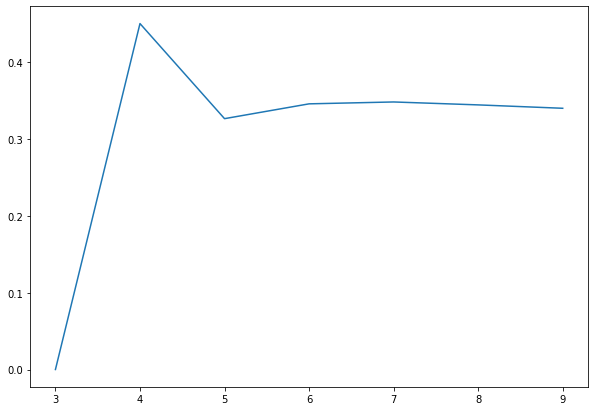

In [13]:
pd.Series(k_vs_score,index = range(3,Xtrain0.shape[1])).plot(figsize=(10,7))

In [14]:
selectorfinal=SelectKBest(score_func=f_classif, k = 6).fit(Xtrain0,ytrain0)
mask0=selectorfinal.get_support()
Xtrain0.columns[mask0]

Index(['age', 'region_code', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'policy_sales_channel'],
      dtype='object')

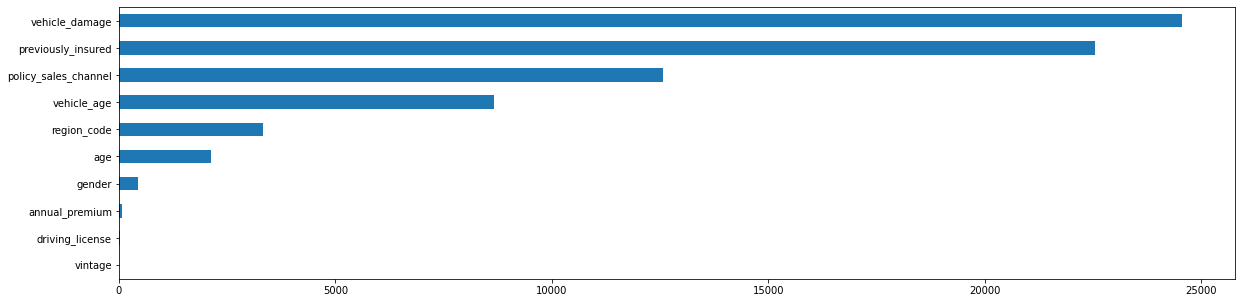

In [15]:
pd.Series(selector.scores_, index=Xtrain.columns).sort_values(ascending=True).plot.barh()
plt.gcf().set_size_inches(20,5)

# 7.0 MACHINE LEARNING MODELLING

In [76]:
Xtrain1=Xtrain.iloc[:,selectorfinal.get_support()]
Xval1=Xval.iloc[:,selectorfinal.get_support()]
#Xtest1=test.iloc[:,selectorfinal.get_support()]


## 7.1 Average Model

In [77]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# prediction
pred_random = np.random.choice([0,1],yval.shape[0])

# performance
results_bs = precision_recall_fscore_support(yval,pred_random)
results_bs=pd.DataFrame(results_bs,index=['precision','recall','fscore','support'])
results_bs=results_bs.iloc[:-1,-1].to_frame('metrics').T
results_bs['model']='average'
results_bs

,precision,recall,fscore,model
metrics,0.12284,0.50050,0.19727,average


## 7.2 RandomForestClassifier

In [82]:
rf=RandomForestClassifier(n_estimators=100,random_state=42)
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    pred=rf.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))

dic_results_rf={"precision":precisions,"recall":recalls,"fscore":fscores}
results_rf=pd.DataFrame.from_dict(dic_results_rf)
results_rf=results_rf.mean().to_frame(name='metrics').T
results_rf['model']=rf.__class__.__name__
results_rf

,precision,recall,fscore,model
metrics,0.33844,0.12107,0.17833,RandomForestClassifier


## 7.3 XGBoost Classifier

In [83]:
xb = XGBClassifier(n_estimators=100,random_state=42)
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    xb.fit(x_train_fold, y_train_fold)
    pred=xb.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))


dic_results_xb={"precision":precisions,"recall":recalls,"fscore":fscores}
results_xb=pd.DataFrame.from_dict(dic_results_xb)
results_xb=results_xb.mean().to_frame(name='metrics').T
results_xb['model']=xb.__class__.__name__
results_xb

,precision,recall,fscore,model
metrics,0.44262,0.01991,0.03808,XGBClassifier


## 7.4 LGBMClassifier

In [85]:
lgbm = LGBMClassifier(n_estimators=100,random_state=42)
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
precisions = []
recalls = []
fscores = []

for train_index, test_index in skf.split(Xtrain1, ytrain):
    x_train_fold, x_test_fold = Xtrain1.loc[train_index,:], Xtrain1.loc[test_index,:]
    y_train_fold, y_test_fold = ytrain.loc[train_index], ytrain.loc[test_index]
    lgbm.fit(x_train_fold, y_train_fold)
    pred=lgbm.predict(x_test_fold)
    precisions.append(precision_score(y_test_fold,pred))
    recalls.append(recall_score(y_test_fold,pred))
    fscores.append(f1_score(y_test_fold,pred))

dic_results_lgbm={"precision":precisions,"recall":recalls,"fscore":fscores}
results_lgbm=pd.DataFrame.from_dict(dic_results_lgbm)
results_lgbm=results_lgbm.mean().to_frame(name='metrics').T
results_lgbm['model']=lgbm.__class__.__name__
results_lgbm

,precision,recall,fscore,model
metrics,0.53941,0.00403,0.00800,LGBMClassifier


## 7.6 Compare Models Performance

In [86]:
modelling_result=pd.concat([results_bs,results_rf,results_xb,results_lgbm])
modelling_result

,precision,recall,fscore,model
metrics,0.12284,0.50050,0.19727,average
metrics,0.33844,0.12107,0.17833,RandomForestClassifier
metrics,0.44262,0.01991,0.03808,XGBClassifier
metrics,0.53941,0.00403,0.00800,LGBMClassifier


# 8.0 HYPERPARAMETER TUNING

In [100]:
params = {
    'n_estimators': [25, 50, 100],
    'max_depth' : [5,10,15],
    'criterion' :['gini', 'entropy'],
    "min_samples_split": [2,5,10],
    "bootstrap":[True],
    "min_samples_leaf":[5,8,12]
}
rf_tuning=RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = rf_tuning, param_distributions = params,scoring='precision', n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

rf_random.fit(Xtrain1, ytrain)

print(rf_random.cv_results_, rf_random.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'mean_fit_time': array([31.54310006, 14.95373625, 32.20557839, 19.25112081, 12.29410648,
       35.92870498, 24.98955292,  9.43646324, 12.00532871,  9.32097542]), 'std_fit_time': array([1.01279334, 0.32831431, 0.39720429, 0.71427524, 0.89708326,
       1.19435294, 1.89589572, 1.33643305, 1.28718374, 1.00507179]), 'mean_score_time': array([2.22792023, 0.84530157, 2.24545753, 1.3124404 , 0.75599116,
       2.04264337, 1.70002842, 0.4827922 , 0.69508225, 0.45513439]), 'std_score_time': array([0.41508978, 0.12767729, 0.41635499, 0.24779942, 0.15585712,
       0.41070178, 0.41863176, 0.04420705, 0.18777737, 0.07708153]), 'param_n_estimators': masked_array(data=[100, 50, 100, 50, 50, 100, 100, 25, 50, 25],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[5, 2, 5, 2, 5, 2, 2, 10

## 8.1 Final Model

In [104]:
param_tuned = rf_random.best_params_
param_tuned

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': True}

In [107]:
# model
rf_final = RandomForestClassifier( 
                                    min_samples_split=param_tuned['min_samples_split'],
                                    min_samples_leaf=param_tuned['min_samples_leaf'],
                                    n_estimators=param_tuned['n_estimators'], 
                                    max_depth=param_tuned['max_depth'], 
                                    criterion=param_tuned['criterion'],
                                    random_state=42).fit( Xtrain1, ytrain )

# prediction
ypredtrain = rf_final.predict(Xtrain1)
#ypredtest = rf_final.predict(Xtest)


# performance
precision_recall_fscore_support(ytrain,ypredtrain)

(array([0.87760548, 0.76666667]),
 array([0.99993022, 0.00164133]),
 array([0.93478301, 0.00327565]),
 array([200639,  28026], dtype=int64))

# 9.0 ERROR INTERPRETATION TO BUSINESS

In [ ]:
df9 = test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions']= np.expm1(ypred_xgb_tuned)
df9.head(1)

## 9.1 business performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
sns.scatterplot(x='store',y='MAPE',data=df92)

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head()

## 9.2 total performance

In [ ]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']=df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3 machine learning performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# CLASS PREDICTOR

In [ ]:
import pickle
import pandas as pd
import numpy as np
import math, datetime

class pipe_insurance( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\insurance_cross'
        self.oe = pickle.load( open( self.home_path + r'\parameters\oe_vehicle_age_gender_vehicle_damage.pkl', 'rb') )
        self.mss = pickle.load( open( self.home_path + r'\parameters\age_mms_scaler.pkl', 'rb') )
        self.ss = pickle.load( open( self.home_path + r'\parameters\annual_premium_robust_scaler.pkl', 'rb') )
        self.rs = pickle.load( open( self.home_path + r'\parameters\vintage_ss_scaler.pkl', 'rb') )

        
    def data_cleaning( self, df1 ): 
        
        df1.columns=df1.columns.str.lower()

        for i in ['region_code','policy_sales_channel']:
                df1[i]=df1[i].astype('object')

        df1['vehicle_age']=df1['vehicle_age'].map({'> 2 Years':'2. 2_more_years','1-2 Year':'1. 1_2_years', '< 1 Year': '0. 1_less_years'})

        return df1

    def feature_engineering( self, df2):
        return df2

        
    def data_preparation( self, df3 ):
        df3[['vehicle_age','gender','vehicle_damage']]=oe.transform(df3[['vehicle_age','gender','vehicle_damage']])
        df3['age'] = mms.transform( df3[['age']].values )
        df3['vintage'] = ss.transform( df3[['vintage']].values )
        df3['annual_premium'] = rs.transform( df3[['annual_premium']].values )

        return df3
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )



